<a href="https://colab.research.google.com/github/Javsk891/Pron-sticoPM2.5-LSTM-Tesis-de-Grado-Javier-Gonzalez/blob/main/Procesamiento_y_modelado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementación de redes neuronales recurrentes LSTM para el pronóstico de material particulado PM2,5 en el Valle de Áburra

Este notebook contiene la implementación de modelos de redes neuronales LSTM (Long Short-Term Memory) para el pronóstico de las concentraciones de material particulado PM2,5 en el Valle de Áburra. Los modelos desarrollados incluyen configuraciones como LSTM, STACKED-LSTM, BI-LSTM y STACKED-BI-LSTM, los cuales han sido entrenados utilizando datos históricos de estaciones de monitoreo del Sistema de Alerta Temprana (SIATA). El enfoque se basa en la capacidad de las redes LSTM para capturar dependencias temporales en series de tiempo, lo que resulta crucial para la predicción precisa de contaminantes en un entorno con variabilidad climática y datos incompletos.

Los datos utilizados en este proyecto incluyen series temporales de concentración de PM2,5 y variables meteorológicas obtenidas entre 2016 y 2024, las cuales presentan algunas discontinuidades y valores faltantes debido a fallos en los instrumentos de medición. Sin embargo, se implementaron técnicas como Transfer Learning para abordar estos desafíos, mejorando la adaptabilidad de los modelos a periodos con datos incompletos. Estos modelos están destinados a optimizar las predicciones en sistemas de alerta temprana, mejorando la gestión de la calidad del aire y la salud pública en la región.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive

In [2]:

# Montar Google Drive
drive.mount('/content/drive')

file_path1 = '/content/drive/My Drive/Datos SIATA/Calidad_PM25_2016_2024.csv'
file_path2 = '/content/drive/My Drive/Datos SIATA/Datos_Meteo_2016_2024.csv'
file_path3 = '/content/drive/My Drive/Datos SIATA/Datos_PM25_2016_2024.csv'

df_pm = pd.read_csv(file_path1)
df_calidad = pd.read_csv(file_path2)
df_meteo = pd.read_csv(file_path3)

Mounted at /content/drive


<ipython-input-2-71385747>:9: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df_calidad = pd.read_csv(file_path2)


# En este bloque de código, se realizan varias operaciones para preparar los datasets antes de su análisis y modelado:

Conversión de la columna 'datetime' a objetos datetime: Para asegurar que las columnas de fechas y horas sean interpretadas correctamente, se convierte la columna 'datetime' en cada uno de los datasets (df_pm, df_meteo, y df_calidad) a objetos de tipo datetime utilizando la función pd.to_datetime(). Esto permite que pandas gestione correctamente las fechas y realice operaciones de tiempo de manera eficiente.

Establecimiento de 'datetime' como índice: En los datasets df_pm y df_meteo, se establece la columna 'datetime' como índice utilizando set_index(). Esto facilita las operaciones basadas en tiempo, como la indexación temporal y la alineación de datos. Para el dataset df_calidad, se cambia el nombre de la columna 'est' a 'datetime' y se establece como índice, asegurando que todos los datasets tengan una estructura consistente.

Limpieza de datos en df_calidad: Se verifica si la columna 'datetime' contiene valores de texto en lugar de fechas. Si el primer valor de esta columna es la cadena 'datetime', que corresponde a un encabezado, se elimina la primera fila del dataset. Esto asegura que los datos estén listos para el análisis sin valores no deseados.

Este procedimiento garantiza que los datasets estén correctamente preparados y organizados por fecha, lo cual es esencial para las tareas de análisis temporal que se realizarán a continuación.

In [3]:
# para los datasets 'df_pm' y 'df_meteo' tomar la columna 'datetime' como índice,  mientras para el dataset 'df_calidad' cambie el nombre de la columna 'est' por 'datetime' y haga este el indice del dataset ç

# Convertir la columna 'datetime' a datetime objects
df_pm['datetime'] = pd.to_datetime(df_pm['datetime'])
df_meteo['datetime'] = pd.to_datetime(df_meteo['datetime'])

# Establecer 'datetime' como índice para df_pm y df_meteo
df_pm = df_pm.set_index('datetime')
df_meteo = df_meteo.set_index('datetime')

# Cambiar el nombre de la columna 'est' a 'datetime' en df_calidad
df_calidad = df_calidad.rename(columns={'est': 'datetime'})

# Check if values in 'datetime' column are strings and not the column name itself
if df_calidad['datetime'].dtype == object and df_calidad['datetime'].iloc[0] == 'datetime':
    df_calidad = df_calidad[1:]  # Remove the first row if it's a header

# Convertir la columna 'datetime' a datetime objects en df_calidad
df_calidad['datetime'] = pd.to_datetime(df_calidad['datetime'], errors='coerce')

# Establecer 'datetime' como índice para df_calidad
df_calidad = df_calidad.set_index('datetime')

<ipython-input-3-670644732>:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_calidad['datetime'] = pd.to_datetime(df_calidad['datetime'], errors='coerce')


In [4]:
# Combinar los DataFrames usando merge con la columna 'datetime' como clave
df_combined = pd.merge(df_pm, df_meteo, left_index=True, right_index=True, how='outer')
df_combined = pd.merge(df_combined, df_calidad, left_index=True, right_index=True, how='outer')

# Eliminar las dos primeras filas del DataFrame
df_combined = df_combined.iloc[2:]

# Asegurarse de que el índice sea de tipo datetime
df_combined.index = pd.to_datetime(df_combined.index)

#La siguiente celda de código permite la creación de un dataset específico
para una estación seleccionada, extrayendo las columnas relevantes del dataset combinado y alineándolas según la columna 'datetime', que es crucial para la correcta manipulación de las series temporales. Este proceso incluye un filtrado basado en la calidad de los datos, utilizando un criterio predefinido para PM2.5, como se detalla en la imagen adjunta. La imputación de valores faltantes se realiza mediante interpolación y un relleno hacia atrás, garantizando la integridad y la continuidad de los datos, lo que es esencial para el entrenamiento de modelos de predicción.

Después de ejecutar este bloque de código, se solicita al usuario ingresar el nombre de una estación previamente utilizada en los modelos de predicción, tales como 'ITA-CJUS', 'ITA-CONC' o 'MED-FISC'. Se recomienda, en la medida de lo posible, utilizar los datos de la estación 'ITA-CJUS', ya que esta ha demostrado ser la más óptima en términos de métricas de evaluación, presentando un rendimiento superior en las pruebas realizadas. Esto se debe a su consistencia temporal y la alta calidad de los registros de PM2.5, factores que han influido significativamente en la precisión y robustez de los modelos implementados.

In [5]:
# Verificar los nombres de las columnas para asegurarse de que 'datetime' esté presente
print("Nombres de las columnas en el dataset combinado:", df_combined.columns.tolist())

# Intentar convertir 'datetime' a formato de fecha si no está ya en el formato correcto
if 'datetime' in df_combined.columns:
    df_combined['datetime'] = pd.to_datetime(df_combined['datetime'], errors='coerce')  # Convertir a fecha, errores se convierten a NaT
else:
    print("Advertencia: La columna 'datetime' no existe en el DataFrame. Se procederá sin ella.")

def create_station_dataset(station_name):
    """
    Crea un nuevo dataset para una estación específica, extrayendo columnas relevantes de un dataset combinado.

    Args:
        station_name: El nombre de la estación.

    Returns:
        Un DataFrame de pandas con las columnas relevantes para la estación especificada, o None si no se encuentran columnas coincidentes.
    """

    # Buscar las columnas que contienen el nombre de la estación en su nombre
    station_columns = [col for col in df_combined.columns if station_name in col]

    # Si no se encuentran columnas correspondientes, mostrar un mensaje y retornar None
    if not station_columns:
        print(f"No se encontraron columnas para la estación '{station_name}' en el dataset combinado.")
        return None

    # Si se encuentran columnas correspondientes, extraerlas
    if 'datetime' in df_combined.columns:
        # Asegurarse de que las columnas estén alineadas por la columna 'datetime'
        station_df = df_combined[['datetime'] + station_columns]
    else:
        # Si no existe 'datetime', usar solo las columnas de la estación
        station_df = df_combined[station_columns]

    # Renombrar las columnas del DataFrame
    new_column_names = ['Calidad del dato', 'Concentración PM2.5', 'DViento_SSR', 'HAire10_SSR', 'PLiquida_SSR',
                        'P_SSR', 'TAire10_SSR', 'VViento_SSR']

    # Verificar que el número de columnas coincida
    if len(station_df.columns) > len(new_column_names):
        print(f"Advertencia: El número de columnas en el dataset excede el número de nombres proporcionados.")
        station_df = station_df.iloc[:, :len(new_column_names)]  # Recortar las columnas si hay más columnas de las esperadas

    # Asignar los nuevos nombres
    station_df.columns = new_column_names[:len(station_df.columns)]

    # Filtrar las filas donde la columna 'Calidad del dato' es 1, -1 o en el rango (1.8, 2.5)
    station_df = station_df[
        (station_df['Calidad del dato'].isin([1, -1])) |
        (station_df['Calidad del dato'].between(1.8, 2.5))
    ]

    # Imputación de valores faltantes (NaN) con interpolación lineal
    station_df = station_df.interpolate(method='linear', limit_direction='forward', axis=0)

    # También podemos aplicar el método de 'backward fill' si es necesario (relleno hacia atrás)
    station_df = station_df.fillna(method='bfill')

    # Eliminar la columna 'Calidad del dato' ya que no será útil para la red neuronal
    station_df = station_df.drop(columns=['Calidad del dato'])

    # Guardar el nuevo dataset con el nombre de la estación, conservando 'datetime' como columna
    #output_file = f"/content/drive/My Drive/Datos SIATA/{station_name}.csv"

    # Guardar el DataFrame asegurando que 'datetime' se mantiene como columna
    #station_df.to_csv(output_file, index=True)

    #print(f"Dataset para la estación '{station_name}' creado exitosamente: {output_file}")
    return station_df

# Solicitar al usuario el nombre de la estación
station_name = input("Ingrese el nombre de la estación (ejemplo: CEN-TRAF): ")

# Crear el dataset para la estación
df = create_station_dataset(station_name)

# Mostrar el nuevo dataset (si fue creado)
if df is not None:
    print(f"\nDataset para la estación '{station_name}':")

Nombres de las columnas en el dataset combinado: ['calidad_CEN-TRAF', 'calidad_ITA-CJUS', 'calidad_ITA-CONC', 'calidad_CAL-JOAR', 'calidad_EST-HOSP', 'calidad_MED-ALTA', 'calidad_MED-VILL', 'calidad_BAR-TORR', 'calidad_COP-CVID', 'calidad_MED-BEME', 'calidad_MED-TESO', 'calidad_MED-SCRI', 'calidad_MED-ARAN', 'calidad_BEL-FEVE', 'calidad_ENV-HOSP', 'calidad_SAB-RAME', 'calidad_MED-SELE', 'calidad_MED-FISC', 'calidad_GIR-EPM', 'calidad_MED-PBLQ', 'calidad_MED-PROV', 'calidad_MED-CES', 'calidad_EST-TABL', 'CEN-TRAF_x', 'ITA-CJUS_x', 'ITA-CONC', 'CAL-JOAR', 'EST-HOSP', 'MED-ALTA', 'MED-VILL', 'BAR-TORR', 'COP-CVID_x', 'MED-BEME', 'MED-TESO', 'MED-SCRI', 'MED-ARAN', 'BEL-FEVE', 'ENV-HOSP', 'SAB-RAME_x', 'MED-SELE_x', 'MED-FISC_x', 'GIR-EPM', 'MED-PBLQ_x', 'MED-PROV_x', 'MED-CES_x', 'EST-TABL', 'V-GIR-EPM', 'V-GIR-EPM.1', 'V-GIR-EPM.2', 'V-GIR-EPM.3', 'V-GIR-EPM.4', 'V-GIR-EPM.5', 'COP-CVID_y', 'COP-CVID.1', 'COP-CVID.2', 'COP-CVID.3', 'COP-CVID.4', 'COP-CVID.5', 'MED-PBLQ_y', 'MED-PBLQ.1', 

<ipython-input-5-4183315843>:56: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  station_df = station_df.interpolate(method='linear', limit_direction='forward', axis=0)
<ipython-input-5-4183315843>:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_df = station_df.fillna(method='bfill')
<ipython-input-5-4183315843>:59: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  station_df = station_df.fillna(method='bfill')


In [6]:
# Convertir df a escala diaria, usando un promedio movil de 24 horas para cada variable

# Aplicar un promedio móvil de 24 horas para cada variable
df = df.rolling(window=24).mean().resample('D').mean()

In [7]:
if station_name == 'ITA-CJUS':
  df = df.drop(columns=['PLiquida_SSR'])

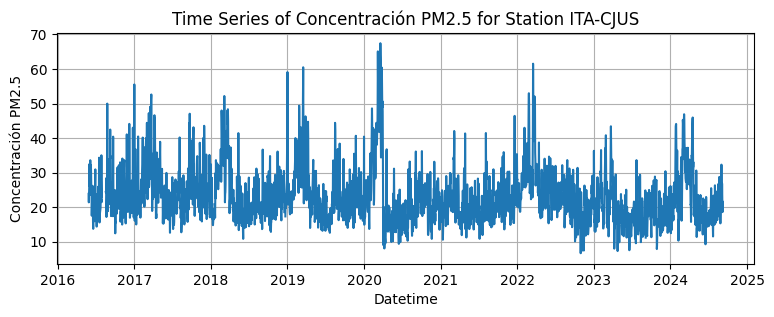

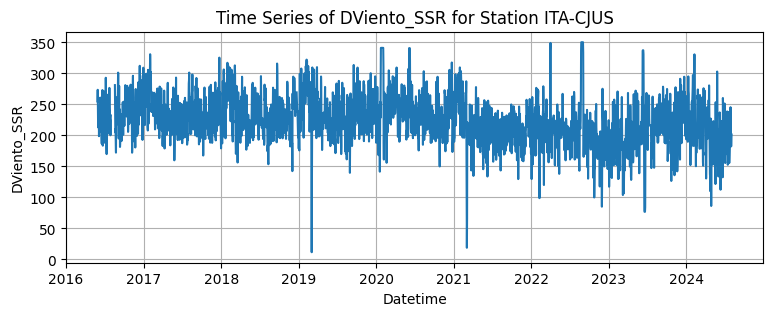

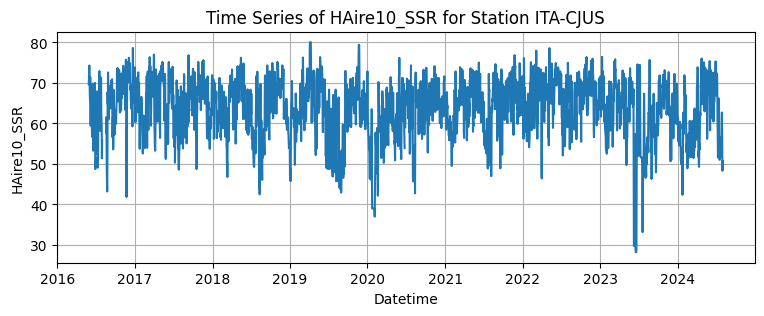

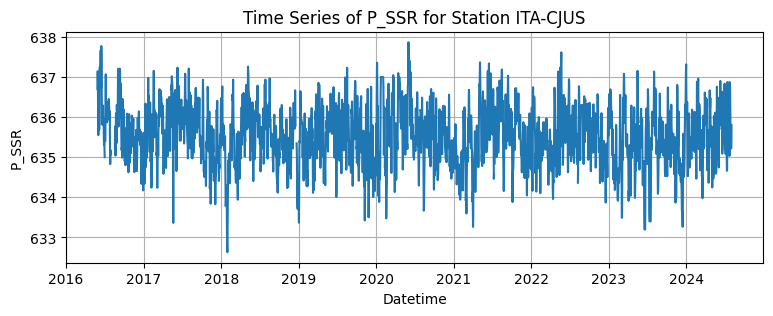

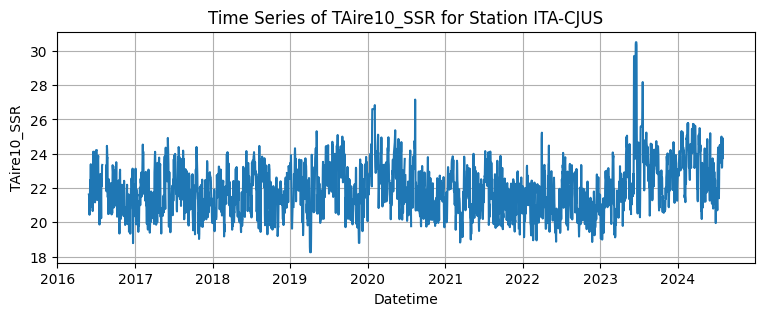

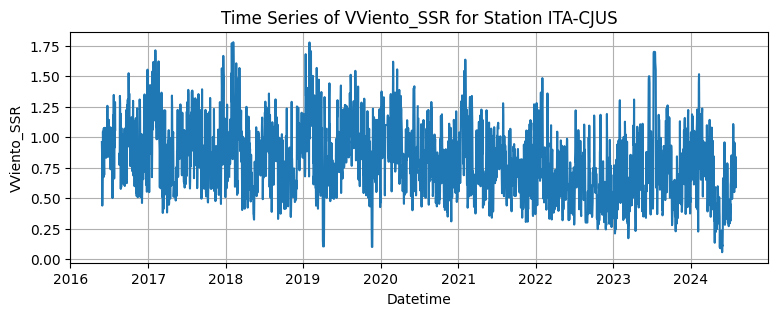

In [8]:
# GRAFICAR LAS LÍNEAS DE TIMEPO INDIVIDUALES PARA CADA UNA DE LAS VARIABLES DEL DATASET df

if df is not None:
  # Ensure all columns are numeric before plotting
  for column in df.columns:
      df[column] = pd.to_numeric(df[column], errors='coerce')

  for column in df.columns:
      plt.figure(figsize=(9, 3))
      plt.plot(df.index, df[column])
      plt.title(f'Time Series of {column} for Station {station_name}')
      plt.xlabel('Datetime')
      plt.ylabel(column)
      plt.grid(True)
      plt.show()

#LSTM

La red neuronal utilizada en este código es un modelo LSTM secuencial, con una arquitectura que incluye una capa LSTM y Dropout para la predicción de la concentración de PM2,5. El modelo comienza con una capa LSTM de 128 unidades y return_sequences=True, lo que permite que las secuencias completas de entrada se pasen a la siguiente capa. A continuación, se agrega una capa Dense con 12 unidades y activación ReLU, seguida de una capa Dropout con una tasa de 0.2 para regularización. Finalmente, el modelo cuenta con una capa de salida Dense con una unidad y activación lineal, lo que es apropiado para un problema de regresión como el pronóstico de concentraciones de PM2,5.

El modelo se compila con el optimizador Adam y utiliza una función de pérdida personalizada denominada Mean Root Squared Error (MRSE), diseñada específicamente para tareas de regresión de series temporales. Además, se emplea Transfer Learning en la fase de fine-tuning: primero, el modelo se entrena utilizando una ventana de tiempo con datos completos (ventana 1), y posteriormente se ajusta con otra ventana de tiempo que contiene datos incompletos (ventana 2). Este enfoque ayuda a mejorar la precisión del modelo y aprovechar mejor la información disponible, incluso cuando los datos son fragmentarios. El entrenamiento se regula mediante early stopping, lo que permite evitar el sobreajuste y optimizar el rendimiento del modelo en un conjunto de validación.

Valores faltantes después de imputación:
Concentración PM2.5    0
DViento_SSR            0
HAire10_SSR            0
P_SSR                  0
TAire10_SSR            0
VViento_SSR            0
dtype: int64
Concentración PM2.5    0
DViento_SSR            0
HAire10_SSR            0
P_SSR                  0
TAire10_SSR            0
VViento_SSR            0
dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.9336 - val_loss: 0.8037
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9217 - val_loss: 0.8378
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8864 - val_loss: 0.7861
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8853 - val_loss: 0.8068
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8258 - val_loss: 0.8259
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8022 - val_loss: 0.8452
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7814 - val_loss: 0.8101
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7814 - val_loss: 0.8089
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7909 - val_loss: 0.8430
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7580 - val_loss: 0.7998
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7965 - val_loss: 0.7995
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

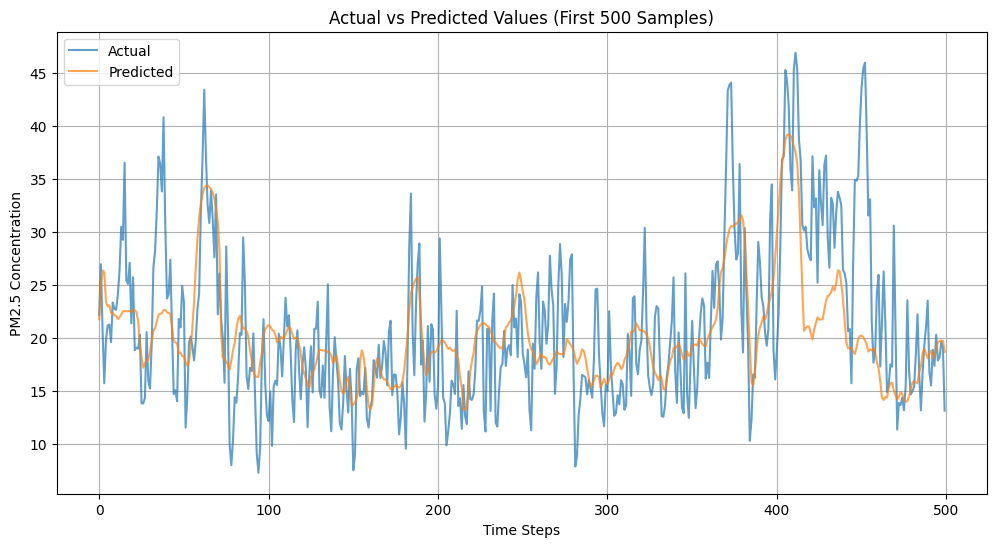

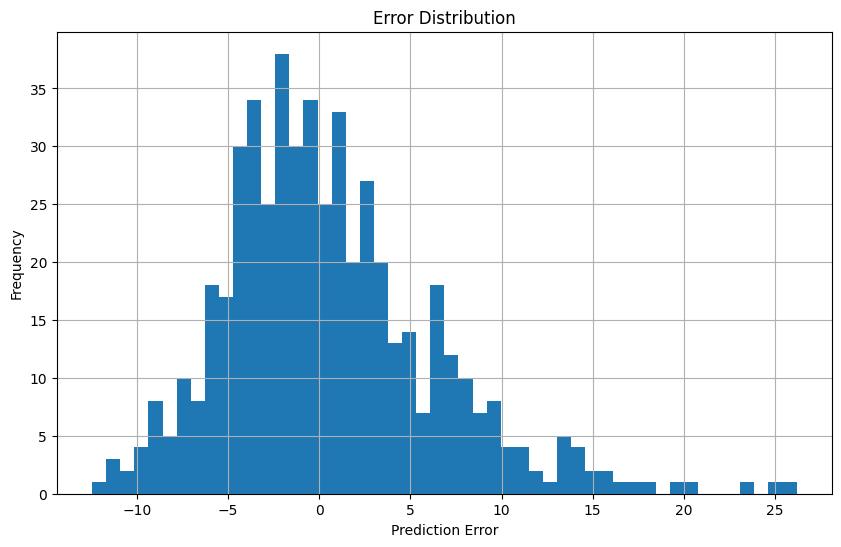

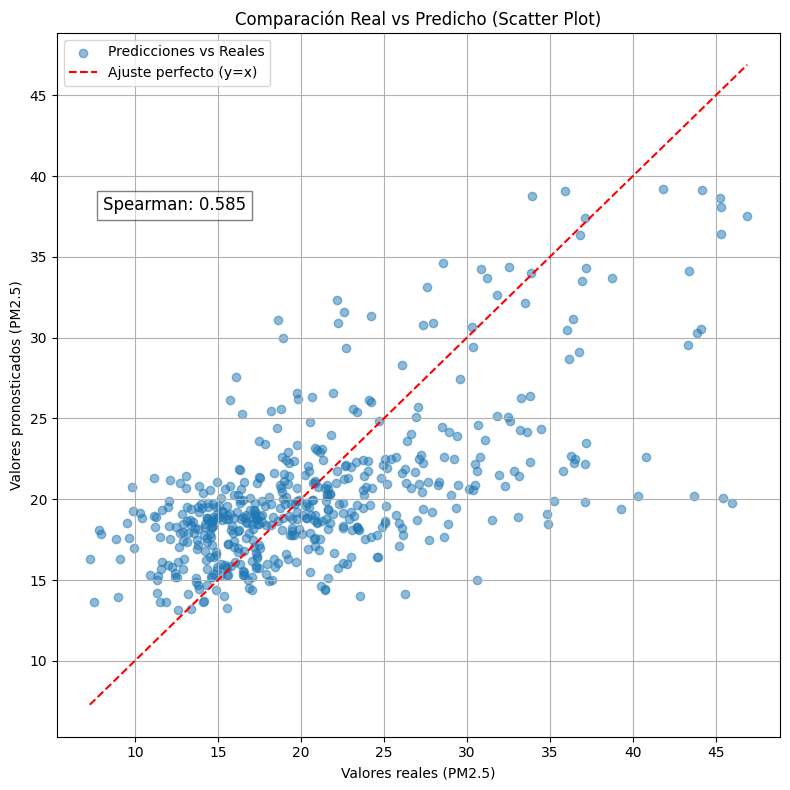

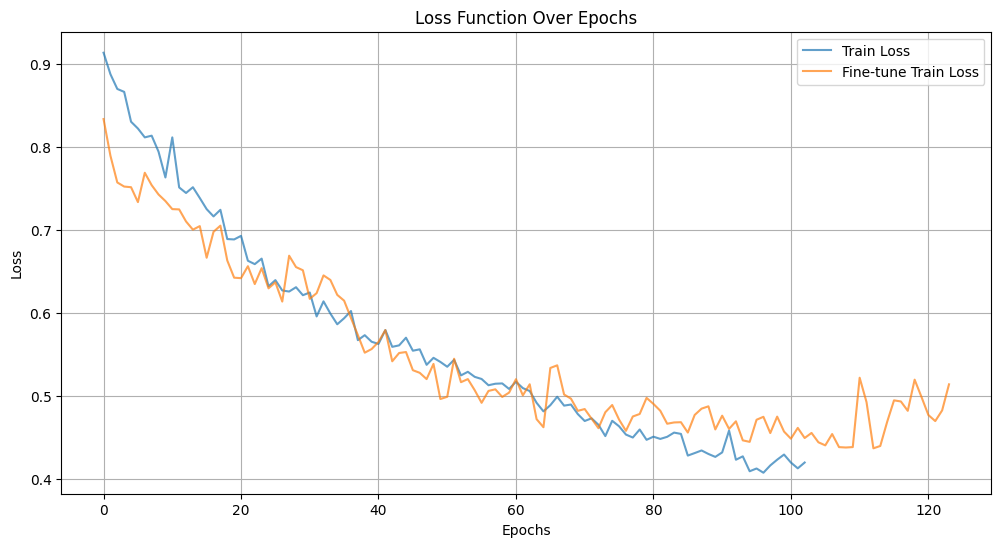

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, cohen_kappa_score
from scipy.stats import pearsonr, spearmanr
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt # Import matplotlib.pyplot

# --- Suposiciones ---
# df ya cargado con índice datetime y columnas:
# 'Concentración PM2.5', 'DViento_SSR', 'HAire10_SSR', 'Pliquida_SSR', 'P_SSR', 'TAire10_SSR', 'Viento_SSR'

# Filtrar ventanas temporales
if station_name == 'MED-FISC':
  window1 = df.loc['2021-07-01':'2023-03-31']
  window2 = df.loc['2023-07-01':'2024-04-15']
elif station_name == 'ITA-CONC':
  window1 = df.loc['2016-09-01':'2018-11-28']
  window2 = df.loc['2023-01-01':'2024-06-15']
elif station_name == 'CEN-TRAF':
  window1 = df.loc['2016-07-01':'2018-02-28']
  window2 = df.loc['2023-01-01':'2024-06-15']
elif station_name == 'ITA-CJUS':
  window1 = df.loc['2017-01-01':'2022-12-31']
  window2 = df.loc['2022-12-31':'2024-06-15']
else:
  print('Ingrese una estación con calidad del dato adecuada para el modelo')
  # Exit the cell execution if the station is not supported
  raise ValueError("Unsupported station for model training")

# Variables predictoras y objetivo
if station_name == 'ITA-CJUS':
  features = ['DViento_SSR', 'HAire10_SSR', 'P_SSR', 'TAire10_SSR', 'VViento_SSR']
  target = 'Concentración PM2.5'
else:
  features = ['DViento_SSR', 'HAire10_SSR', 'PLiquida_SSR', 'P_SSR', 'TAire10_SSR', 'VViento_SSR']
  target = 'Concentración PM2.5'

# Imputación KNN independiente por ventana
imputer1 = KNNImputer(n_neighbors=5)
window1_imputed = imputer1.fit_transform(window1)
window1 = pd.DataFrame(window1_imputed, columns=window1.columns, index=window1.index)

imputer2 = KNNImputer(n_neighbors=5)
window2_imputed = imputer2.fit_transform(window2)
window2 = pd.DataFrame(window2_imputed, columns=window2.columns, index=window2.index)

print("Valores faltantes después de imputación:")
print(window1.isnull().sum())
print(window2.isnull().sum())

# Escalado robusto para mitigar outliers
scaler_x = RobustScaler()
scaler_y = RobustScaler()

X1_scaled = scaler_x.fit_transform(window1[features])
y1_scaled = scaler_y.fit_transform(window1[[target]])

X2_scaled = scaler_x.transform(window2[features])
y2_scaled = scaler_y.transform(window2[[target]])

# Crear secuencias para LSTM
def create_sequences(X, y, time_steps=20):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 20

from tensorflow.keras import backend as K
def mrse(y_true, y_pred):
    """Función de pérdida personalizada: Mean Root Squared Error (MRSE)"""
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

X_train, y_train = create_sequences(X1_scaled, y1_scaled, time_steps)
X_finetune, y_finetune = create_sequences(X2_scaled, y2_scaled, time_steps)

# Definir modelo LSTM con una sola capa LSTM
def build_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))  # Solo una capa LSTM
    model.add(Dropout(0.3))
    model.add(Dense(12, 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, 'linear'))
    model.compile(optimizer='adam', loss=mrse)
    return model

model = build_model()

# Entrenamiento ventana 1
es = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history1 = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=24,
    validation_split=0.2,
    callbacks=[es]
)

# Transfer learning: fine-tuning ventana 2
history2 = model.fit(
    X_finetune, y_finetune,
    epochs=200,
    batch_size=24,
    validation_split=0.2,
    callbacks=[es]
)

# Predicciones desescaladas
y_pred_scaled = model.predict(X_finetune)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Valores reales para comparación
y_true = window2[target].iloc[time_steps:].values

# Print the lengths, check for NaNs and data types, and print first few elements
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")
print(f"NaNs in y_true: {np.isnan(y_true).sum()}")
print(f"NaNs in y_pred: {np.isnan(y_pred).sum()}")
print(f"Data type of y_true: {y_true.dtype}")
print(f"Data type of y_pred: {y_pred.dtype}")
print(f"First 5 elements of y_true: {y_true[:5]}")
print(f"First 5 elements of y_pred: {y_pred[:5]}")

# Convert y_true and y_pred to numpy arrays before calculating metrics
y_true_np = np.asarray(y_true)
y_pred_np = np.asarray(y_pred)


# Métricas
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

pearson_corr, _ = pearsonr(y_true_np, y_pred_np)
spearman_corr, _ = spearmanr(y_true_np, y_pred_np)
r2 = r2_score(y_true_np, y_pred_np)
mae = mean_absolute_error(y_true_np, y_pred_np)
mape = mean_absolute_percentage_error(y_true_np, y_pred_np)
rmse = root_mean_squared_error(y_true_np, y_pred_np)
mse = mean_squared_error(y_true_np, y_pred_np)

print(f'Pearson correlation: {pearson_corr:.4f}')
print(f'Spearman correlation: {spearman_corr:.4f}')
print(f'R2: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')

# Kappa: discretizamos en 5 bins para regresión
bins = 5
# Check if there are enough unique values for qcut
if len(np.unique(y_true_np)) >= bins and len(np.unique(y_pred_np)) >= bins:
    y_true_cat = pd.qcut(y_true_np, bins, labels=False, duplicates='drop')
    y_pred_cat = pd.qcut(y_pred_np, bins, labels=False, duplicates='drop')
    kappa = cohen_kappa_score(y_true_cat, y_pred_cat)
    print(f'Cohen\'s Kappa (discretizado en {bins} bins): {kappa:.4f}')
else:
    print(f'Skipping Cohen\'s Kappa calculation: Not enough unique values in y_true or y_pred for {bins} bins.')


# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_true[:500], label='Actual', alpha=0.7)
plt.plot(y_pred[:500], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values (First 500 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid()
plt.show()

# Error distribution plot
errors = y_true_np - y_pred_np
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Calcular Spearman correlation
spearman_corr, spearman_p_value = spearmanr(y_true, y_pred)

# Crear gráfico
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, label='Predicciones vs Reales')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ajuste perfecto (y=x)')

# Añadir texto con la correlación de Spearman
plt.text(
    min(y_true) + 0.02 * (max(y_true) - min(y_true)),
    max(y_pred) - 0.05 * (max(y_pred) - min(y_pred)),
    f'Spearman: {spearman_corr:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.5)
)

plt.xlabel('Valores reales (PM2.5)')
plt.ylabel('Valores pronosticados (PM2.5)')
plt.title('Comparación Real vs Predicho (Scatter Plot)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Gráfico de la función de pérdida ---
plt.figure(figsize=(12, 6))
plt.plot(history1.history['loss'], label='Train Loss', alpha=0.7)
plt.plot(history2.history['loss'], label='Fine-tune Train Loss', alpha=0.7)
plt.title('Loss Function Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#Arquiitectura de la red neuronal que acabe de correr

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │         1,548 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,509 (822.30 KB)

 Trainable params: 70,169 (274.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 140,340 (548.21 KB)

# STACKED-LSTM

###STACKED-LSTM (capas apiladas) es un modelo LSTM secuencial con múltiples capas, diseñado para predecir la concentración de PM2,5 a partir de datos meteorológicos. La arquitectura consta de tres capas LSTM: la primera capa tiene 128 unidades con return_sequences=True, lo que permite la conexión con la siguiente capa LSTM; la segunda capa tiene 64 unidades y también retorna secuencias, y la tercera capa tiene 32 unidades con la activación tanh. Entre cada capa LSTM se incluye una capa Dropout con tasas de 0.3 y 0.2, respectivamente, para evitar el sobreajuste. Finalmente, la red se complementa con una capa Dense de 12 unidades con activación ReLU y una capa final Dense de una unidad con activación lineal, adecuada para la predicción continua de la concentración de PM2,5.

###El modelo se entrena utilizando el optimizador Adam y una función de pérdida personalizada llamada Mean Root Squared Error (MRSE), que está diseñada para abordar la regresión de series temporales. Además, el modelo incorpora Transfer Learning durante la fase de fine-tuning, lo que permite adaptar el modelo entrenado en una ventana temporal con datos completos a otra ventana con datos incompletos. El entrenamiento se realiza con early stopping, que detiene el proceso si no se mejora el rendimiento durante 100 épocas consecutivas. Esta configuración permite aprovechar los datos disponibles de manera eficiente y lograr un modelo robusto para las predicciones.

Valores faltantes después de imputación:
Concentración PM2.5    0
DViento_SSR            0
HAire10_SSR            0
P_SSR                  0
TAire10_SSR            0
VViento_SSR            0
dtype: int64
Concentración PM2.5    0
DViento_SSR            0
HAire10_SSR            0
P_SSR                  0
TAire10_SSR            0
VViento_SSR            0
dtype: int64
Epoch 1/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.9139 - val_loss: 0.8035
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8855 - val_loss: 0.8288
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8920 - val_loss: 0.8277
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8141 - val_loss: 0.7894
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8459 - val_loss: 0.8302
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8106 - val_loss: 0.8375
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8008 - val_loss: 0.8185
Epoch 8/200
73/73 ━━━━━━━━━━━━━

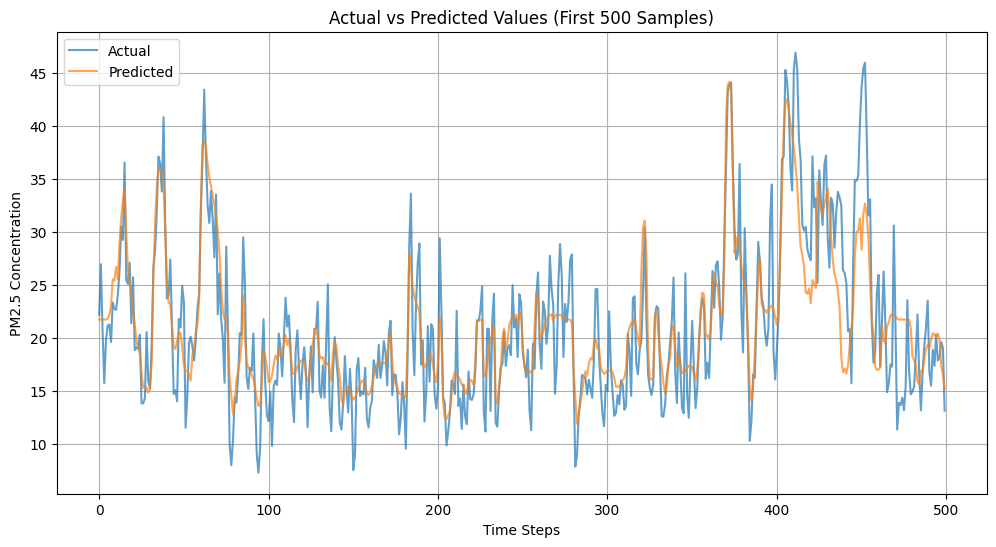

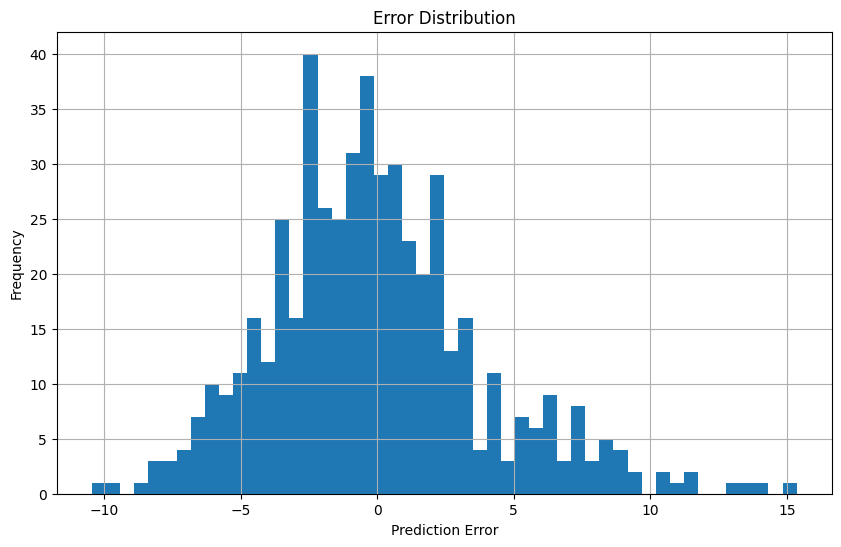

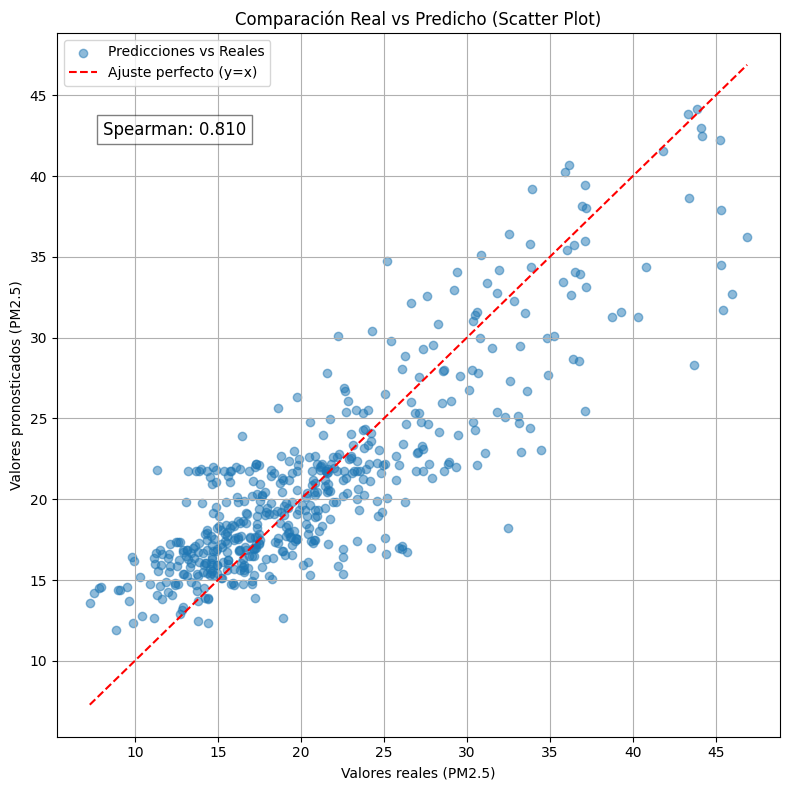

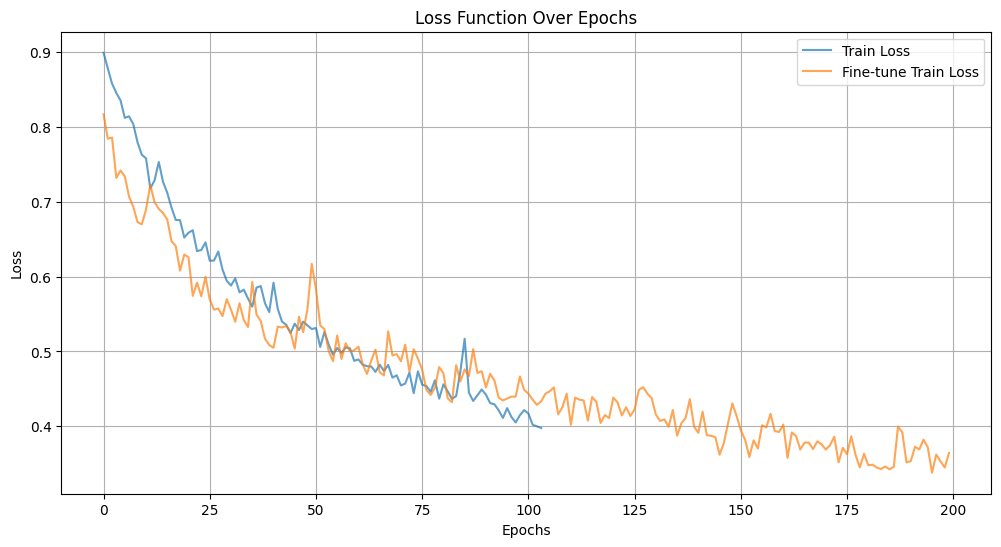

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, cohen_kappa_score
from scipy.stats import pearsonr, spearmanr
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# --- Suposiciones ---
# df ya cargado con índice datetime y columnas:
# 'Concentración PM2.5', 'DViento_SSR', 'HAire10_SSR', 'Pliquida_SSR', 'P_SSR', 'TAire10_SSR', 'Viento_SSR'

# Filtrar ventanas temporales
if station_name == 'MED-FISC':
  window1 = df.loc['2021-07-01':'2023-03-31']
  window2 = df.loc['2023-07-01':'2024-04-15']
elif station_name == 'ITA-CONC':
  window1 = df.loc['2016-09-01':'2018-11-28']
  window2 = df.loc['2023-01-01':'2024-06-15']
elif station_name == 'CEN-TRAF':
  window1 = df.loc['2016-07-01':'2018-02-28']
  window2 = df.loc['2023-01-01':'2024-06-15']
elif station_name == 'ITA-CJUS':
  window1 = df.loc['2017-01-01':'2022-12-31']
  window2 = df.loc['2022-12-31':'2024-06-15']
else:
  print('Ingrese una estación con calidad del dato adecuada para el modelo')

# Variables predictoras y objetivo
if station_name == 'ITA-CJUS':
  features = ['DViento_SSR', 'HAire10_SSR', 'P_SSR', 'TAire10_SSR', 'VViento_SSR']
  target = 'Concentración PM2.5'
else:
  features = ['DViento_SSR', 'HAire10_SSR', 'PLiquida_SSR', 'P_SSR', 'TAire10_SSR', 'VViento_SSR']
  target = 'Concentración PM2.5'

# Imputación KNN independiente por ventana
imputer1 = KNNImputer(n_neighbors=5)
window1_imputed = imputer1.fit_transform(window1)
window1 = pd.DataFrame(window1_imputed, columns=window1.columns, index=window1.index)

imputer2 = KNNImputer(n_neighbors=5)
window2_imputed = imputer2.fit_transform(window2)
window2 = pd.DataFrame(window2_imputed, columns=window2.columns, index=window2.index)

print("Valores faltantes después de imputación:")
print(window1.isnull().sum())
print(window2.isnull().sum())

# Escalado robusto para mitigar outliers
scaler_x = RobustScaler()
scaler_y = RobustScaler()

X1_scaled = scaler_x.fit_transform(window1[features])
y1_scaled = scaler_y.fit_transform(window1[[target]])

X2_scaled = scaler_x.transform(window2[features])
y2_scaled = scaler_y.transform(window2[[target]])

# Crear secuencias para LSTM
def create_sequences(X, y, time_steps=20):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 20

from tensorflow.keras import backend as K
def mrse(y_true, y_pred):
    """Función de pérdida personalizada: Mean Root Squared Error (MRSE)"""
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

X_train, y_train = create_sequences(X1_scaled, y1_scaled, time_steps)
X_finetune, y_finetune = create_sequences(X2_scaled, y2_scaled, time_steps)

# Definir modelo LSTM sofisticado con capa Bidirectional
def build_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(12, 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, 'linear'))
    model.compile(optimizer='adam', loss= mrse)
    return model

model = build_model()

# Entrenamiento ventana 1
es = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history1 = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=24,
    validation_split=0.2,
    callbacks=[es]
)

# Transfer learning: fine-tuning ventana 2
history2 = model.fit(
    X_finetune, y_finetune,
    epochs=200,
    batch_size=24,
    validation_split=0.2,
    callbacks=[es]
)

# Predicciones desescaladas
y_pred_scaled = model.predict(X_finetune)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Valores reales para comparación
y_true = window2[target].iloc[time_steps:].values

# Métricas
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

pearson_corr, _ = pearsonr(y_true, y_pred)
spearman_corr, _ = spearmanr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

# Kappa: discretizamos en 5 bins para regresión
bins = 5
y_true_cat = pd.qcut(y_true, bins, labels=False, duplicates='drop')
y_pred_cat = pd.qcut(y_pred, bins, labels=False, duplicates='drop')

kappa = cohen_kappa_score(y_true_cat, y_pred_cat)

print(f'Pearson correlation: {pearson_corr:.4f}')
print(f'Spearman correlation: {spearman_corr:.4f}')
print(f'R2: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'Cohen\'s Kappa (discretizado en {bins} bins): {kappa:.4f}')

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_true[:500], label='Actual', alpha=0.7)
plt.plot(y_pred[:500], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values (First 500 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid()
plt.show()

# Error distribution plot
errors = y_true - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Calcular Spearman correlation
spearman_corr, spearman_p_value = spearmanr(y_true, y_pred)

# Crear gráfico
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, label='Predicciones vs Reales')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ajuste perfecto (y=x)')

# Añadir texto con la correlación de Spearman
plt.text(
    min(y_true) + 0.02 * (max(y_true) - min(y_true)),
    max(y_pred) - 0.05 * (max(y_pred) - min(y_pred)),
    f'Spearman: {spearman_corr:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.5)
)

plt.xlabel('Valores reales (PM2.5)')
plt.ylabel('Valores pronosticados (PM2.5)')
plt.title('Comparación Real vs Predicho (Scatter Plot)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Gráfico de la función de pérdida ---
plt.figure(figsize=(12, 6))
plt.plot(history1.history['loss'], label='Train Loss', alpha=0.7)
plt.plot(history2.history['loss'], label='Fine-tune Train Loss', alpha=0.7)
plt.title('Loss Function Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Arquiitectura de la red neuronal que acabe de correr

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 20, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,525 (1.50 MB)

 Trainable params: 130,841 (511.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 261,684 (1022.21 KB)

#Modelos

Las celdas de código desarrolladas y presentadas a continuación están dedicadas a la implementación, entrenamiento y evaluación de diversos modelos predictivos basados en redes neuronales LSTM (Long Short-Term Memory) para la predicción de la concentración de PM2.5 en el Valle de Aburrá. Estos modelos fueron diseñados para capturar las complejas dinámicas temporales de las series de tiempo asociadas a la calidad del aire, utilizando datos históricos provenientes de estaciones de monitoreo como 'ITA-CJUS', 'ITA-CONC' y 'MED-FISC'. En particular, se implementaron diferentes configuraciones de redes LSTM, incluyendo modelos de tipo secuencial, apilados (STACKED-LSTM) y bidireccionales (BI-LSTM), con el objetivo de evaluar cuál de estas arquitecturas proporcionaba la mejor capacidad predictiva para los datos meteorológicos y de calidad del aire.

La evaluación de estos modelos se realizó utilizando métricas estándar en problemas de regresión de series temporales, como el error cuadrático medio (RMSE), el error absoluto medio (MAE) y el coeficiente de determinación (R²). Se prestó especial atención al rendimiento del modelo basado en los datos de la estación 'ITA-CJUS', que ha demostrado ser la más robusta en cuanto a las métricas de evaluación, lo que la convierte en la estación preferida para la implementación y ajustes finos de los modelos. A lo largo de este proceso, también se emplearon técnicas avanzadas de transferencia de aprendizaje (Transfer Learning), lo que permitió mejorar la capacidad de los modelos para adaptarse a periodos de datos incompletos o con baja calidad, optimizando su rendimiento general.

#BI-LSTM

BI-LSTM es un modelo secuencial con una capa Bidireccional (BI-LSTM) para la predicción de la concentración de PM2,5. La arquitectura consta de tres capas LSTM: la primera capa es Bidireccional con 128 unidades y return_sequences=True, lo que permite que la red capture tanto las dependencias temporales pasadas como futuras; la segunda capa tiene 64 unidades con return_sequences=True y la tercera capa tiene 32 unidades con activación tanh. Para prevenir el sobreajuste, se incluyen capas Dropout entre cada capa LSTM, con tasas de 0.3 y 0.2, respectivamente. Finalmente, se añaden dos capas Dense, la primera con 12 unidades y activación ReLU, y la segunda con 1 unidad y activación lineal, adecuada para regresión.

El modelo se entrena con el optimizador Adam y una función de pérdida personalizada llamada Mean Root Squared Error (MRSE), diseñada específicamente para regresión en series temporales. Además, se implementa Transfer Learning durante la fase de fine-tuning, donde el modelo es entrenado inicialmente con una ventana de tiempo con datos completos y luego ajustado con otra ventana con registros incompletos. Este enfoque mejora la eficiencia del modelo, aprovechando el conocimiento adquirido de las ventanas con datos completos para mejorar las predicciones en periodos con menos datos disponibles. El entrenamiento se regula mediante early stopping, con paciencia de 100 épocas, para evitar el sobreajuste y asegurar la mejor capacidad predictiva.

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, cohen_kappa_score
from scipy.stats import pearsonr, spearmanr
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

Valores faltantes después de imputación:
Concentración PM2.5    0
DViento_SSR            0
HAire10_SSR            0
P_SSR                  0
TAire10_SSR            0
VViento_SSR            0
dtype: int64
Concentración PM2.5    0
DViento_SSR            0
HAire10_SSR            0
P_SSR                  0
TAire10_SSR            0
VViento_SSR            0
dtype: int64
Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.9422 - val_loss: 0.8106
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8867 - val_loss: 0.8107
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8283 - val_loss: 0.7991
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8331 - val_loss: 0.8108
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8383 - val_loss: 0.8259
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7981 - val_loss: 0.8358
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7929 - val_loss: 0.8236
Epoch 8/200
72/72 ━━━━━━━━━━━━━

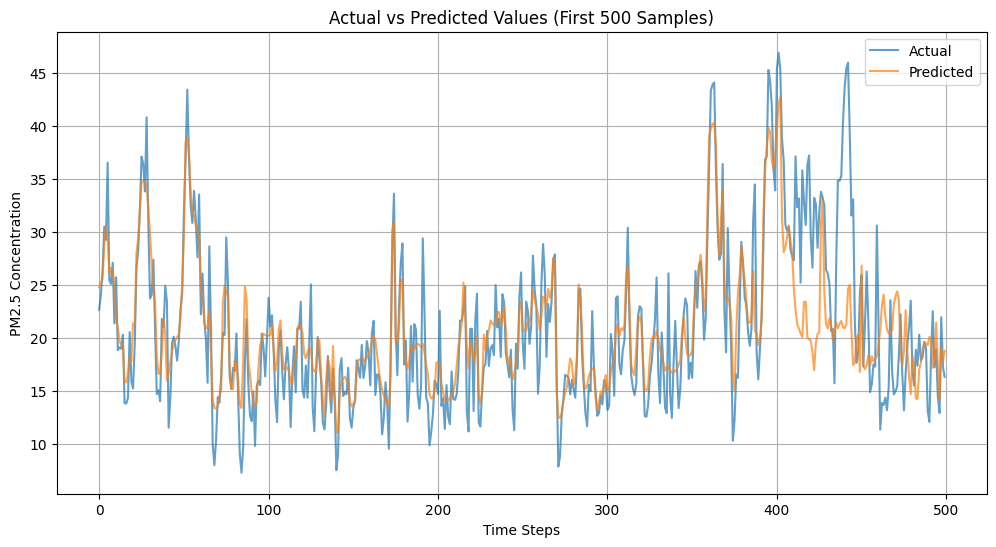

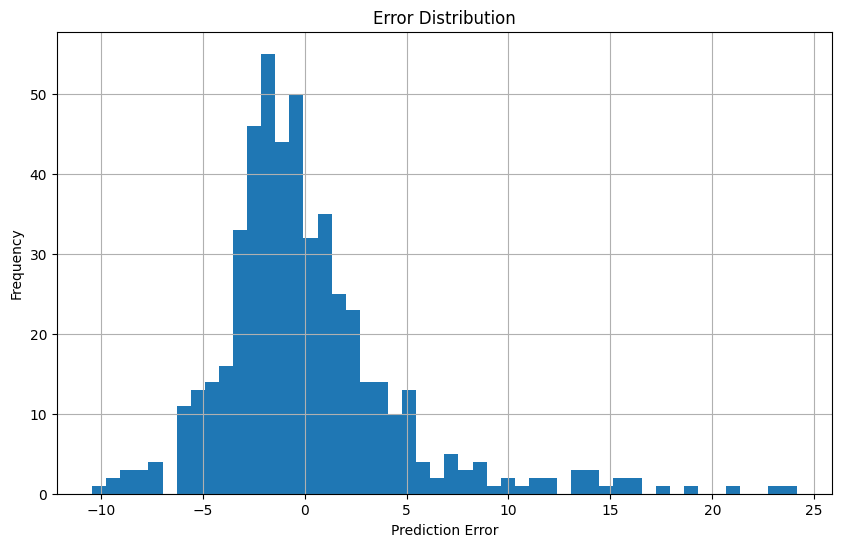

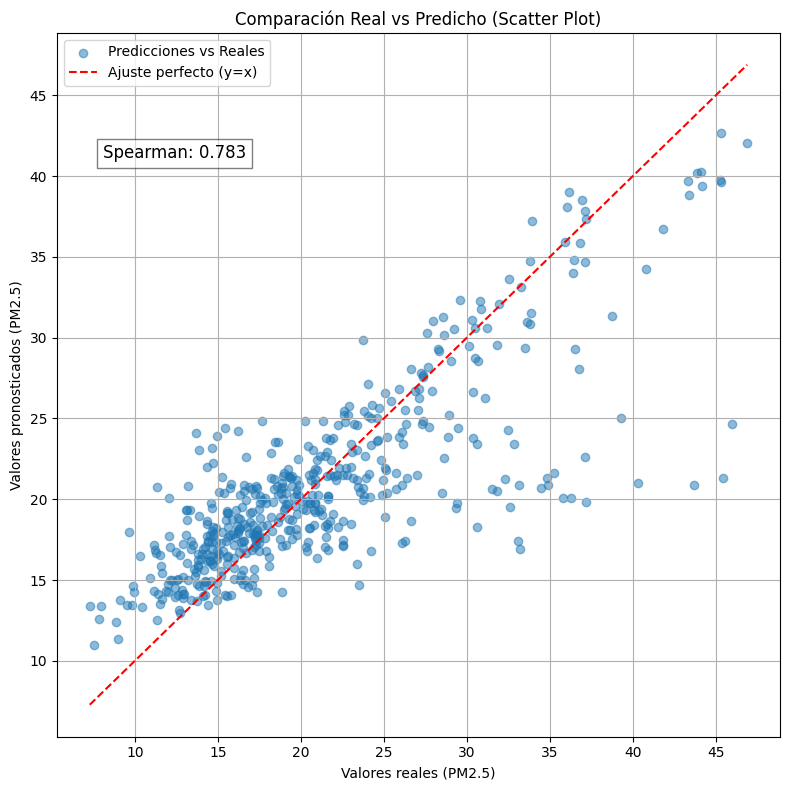

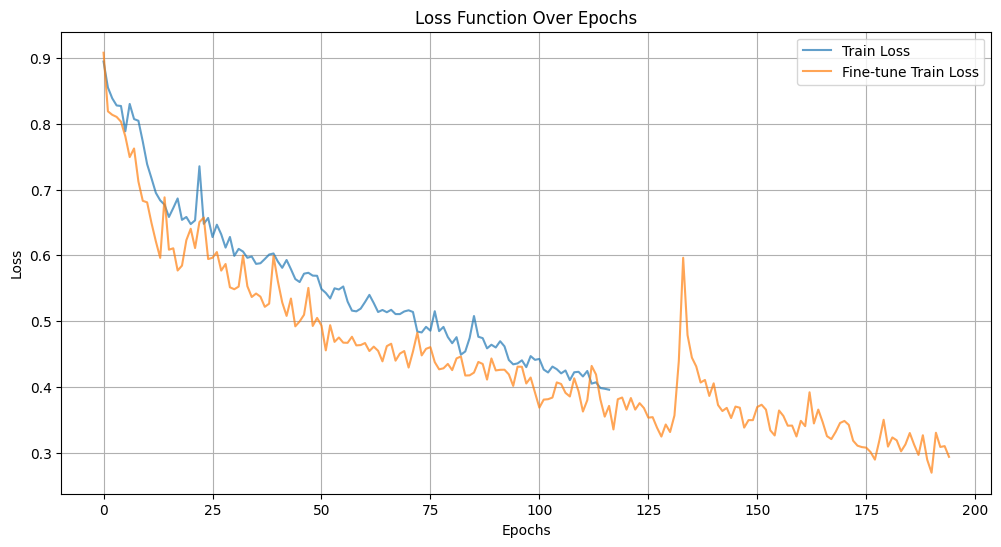

In [11]:
# Filtrar ventanas temporales
if station_name == 'MED-FISC':
  window1 = df.loc['2021-07-01':'2023-03-31']
  window2 = df.loc['2023-07-01':'2024-04-15']
elif station_name == 'ITA-CONC':
  window1 = df.loc['2016-09-01':'2018-11-28']
  window2 = df.loc['2023-01-01':'2024-06-15']
elif station_name == 'CEN-TRAF':
  window1 = df.loc['2016-07-01':'2018-02-28']
  window2 = df.loc['2023-01-01':'2024-06-15']
elif station_name == 'ITA-CJUS':
  window1 = df.loc['2017-01-01':'2022-12-31']
  window2 = df.loc['2022-12-31':'2024-06-15']
else:
  print('Ingrese una estación con calidad del dato adecuada para el modelo')

# Variables predictoras y objetivo
if station_name == 'ITA-CJUS':
  features = ['DViento_SSR', 'HAire10_SSR', 'P_SSR', 'TAire10_SSR', 'VViento_SSR']
  target = 'Concentración PM2.5'
else:
  features = ['DViento_SSR', 'HAire10_SSR', 'PLiquida_SSR', 'P_SSR', 'TAire10_SSR', 'VViento_SSR']
  target = 'Concentración PM2.5'

# Imputación KNN independiente por ventana
imputer1 = KNNImputer(n_neighbors=5)
window1_imputed = imputer1.fit_transform(window1)
window1 = pd.DataFrame(window1_imputed, columns=window1.columns, index=window1.index)

imputer2 = KNNImputer(n_neighbors=5)
window2_imputed = imputer2.fit_transform(window2)
window2 = pd.DataFrame(window2_imputed, columns=window2.columns, index=window2.index)

print("Valores faltantes después de imputación:")
print(window1.isnull().sum())
print(window2.isnull().sum())

# Escalado robusto para mitigar outliers
scaler_x = RobustScaler()
scaler_y = RobustScaler()

X1_scaled = scaler_x.fit_transform(window1[features])
y1_scaled = scaler_y.fit_transform(window1[[target]])

X2_scaled = scaler_x.transform(window2[features])
y2_scaled = scaler_y.transform(window2[[target]])

# Crear secuencias para LSTM
def create_sequences(X, y, time_steps=20):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30

from tensorflow.keras import backend as K
def mrse(y_true, y_pred):
    """Función de pérdida personalizada: Mean Root Squared Error (MRSE)"""
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

X_train, y_train = create_sequences(X1_scaled, y1_scaled, time_steps)
X_finetune, y_finetune = create_sequences(X2_scaled, y2_scaled, time_steps)

# Definir modelo LSTM sofisticado con capa Bidirectional
def build_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, 'tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(12, 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, 'linear'))
    model.compile(optimizer='adam', loss= mrse)
    return model

model = build_model()

# Entrenamiento ventana 1
es = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
history1 = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=24,
    validation_split=0.2,
    callbacks=[es]
)

# Transfer learning: fine-tuning ventana 2
history2 = model.fit(
    X_finetune, y_finetune,
    epochs=200,
    batch_size=24,
    validation_split=0.2,
    callbacks=[es]
)

# Predicciones desescaladas
y_pred_scaled = model.predict(X_finetune)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Valores reales para comparación
y_true = window2[target].iloc[time_steps:].values

# Métricas
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

pearson_corr, _ = pearsonr(y_true, y_pred)
spearman_corr, _ = spearmanr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

print(f'Pearson correlation: {pearson_corr:.4f}')
print(f'Spearman correlation: {spearman_corr:.4f}')
print(f'R2: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_true[:500], label='Actual', alpha=0.7)
plt.plot(y_pred[:500], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values (First 500 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid()
plt.show()

# Error distribution plot
errors = y_true - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()


import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Calcular Spearman correlation
spearman_corr, spearman_p_value = spearmanr(y_true, y_pred)

# Crear gráfico
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, label='Predicciones vs Reales')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ajuste perfecto (y=x)')

# Añadir texto con la correlación de Spearman
plt.text(
    min(y_true) + 0.02 * (max(y_true) - min(y_true)),
    max(y_pred) - 0.05 * (max(y_pred) - min(y_pred)),
    f'Spearman: {spearman_corr:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.5)
)

plt.xlabel('Valores reales (PM2.5)')
plt.ylabel('Valores pronosticados (PM2.5)')
plt.title('Comparación Real vs Predicho (Scatter Plot)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Gráfico de la función de pérdida ---
plt.figure(figsize=(12, 6))
plt.plot(history1.history['loss'], label='Train Loss', alpha=0.7)
# plt.plot(history1.history['val_loss'], label='Validation Loss', alpha=0.7)
plt.plot(history2.history['loss'], label='Fine-tune Train Loss', alpha=0.7)
# plt.plot(history2.history['val_loss'], label='Fine-tune Validation Loss', alpha=0.7)
plt.title('Loss Function Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Arquiitectura de la red neuronal que acabe de correr

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (24, 30, 256)          │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (24, 30, 256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (24, 30, 64)           │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (24, 30, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (24, 32)               │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (24, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (24, 12)               │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (24, 12)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (24, 1)                │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,653 (2.66 MB)

 Trainable params: 232,217 (907.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 464,436 (1.77 MB)

#STACKED-BI-LSTM

###STACKED-BI-LSTM es un modelo secuencial para la predicción de la concentración de PM2,5. La arquitectura consta de varias capas Bidirectional LSTM que permiten capturar las dependencias temporales tanto hacia adelante como hacia atrás en los datos. La primera capa Bidirectional LSTM tiene 256 unidades y está configurada con return_sequences=True, lo que permite que las secuen cias completas se pasen a la siguiente capa. A continuación, se agregan dos capas adicionales de Bidirectional LSTM con 128 y 64 unidades, seguidas de una capa LSTM de 32 unidades con activación tanh. Entre cada capa, se incluyen capas Dropout con tasas de 0.4, 0.3 y 0.2, respectivamente, para evitar el sobreajuste.

###La red termina con una capa Dense de 12 unidades con activación ReLU y una capa de salida Dense con una única unidad y activación lineal, adecuada para la regresión continua.

Valores faltantes después de imputación:
Concentración PM2.5    0
DViento_SSR            0
HAire10_SSR            0
P_SSR                  0
TAire10_SSR            0
VViento_SSR            0
dtype: int64
Concentración PM2.5    0
DViento_SSR            0
HAire10_SSR            0
P_SSR                  0
TAire10_SSR            0
VViento_SSR            0
dtype: int64
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.9592 - val_loss: 0.8101
Epoch 2/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9098 - val_loss: 0.7819
Epoch 3/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9085 - val_loss: 0.8112
Epoch 4/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9054 - val_loss: 0.8011
Epoch 5/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8582 - val_loss: 0.7887
Epoch 6/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8733 - val_loss: 0.8405
Epoch 7/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8327 - val_loss: 0.7886
Epoch 8/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8324 - val_loss: 0.8332
Epoch 9/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8474 - val_loss: 0.8352
Epoch 10/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7591 - val_loss: 0.8213
Epoch 11/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7605 - val_loss: 0.8045
Epoch 12/200
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8

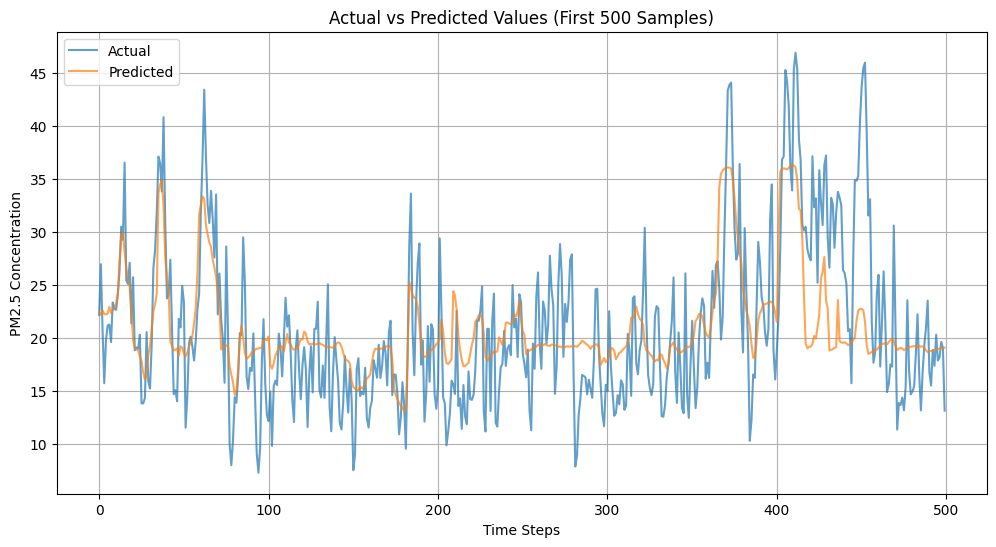

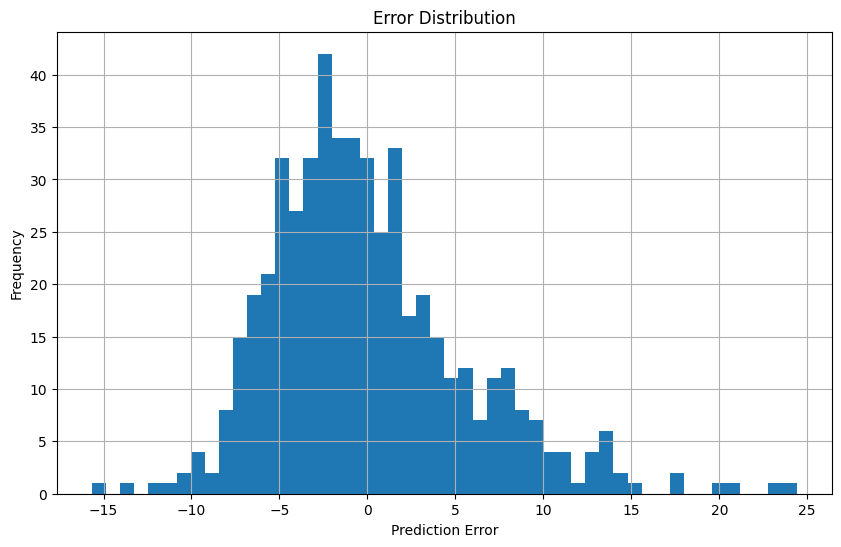

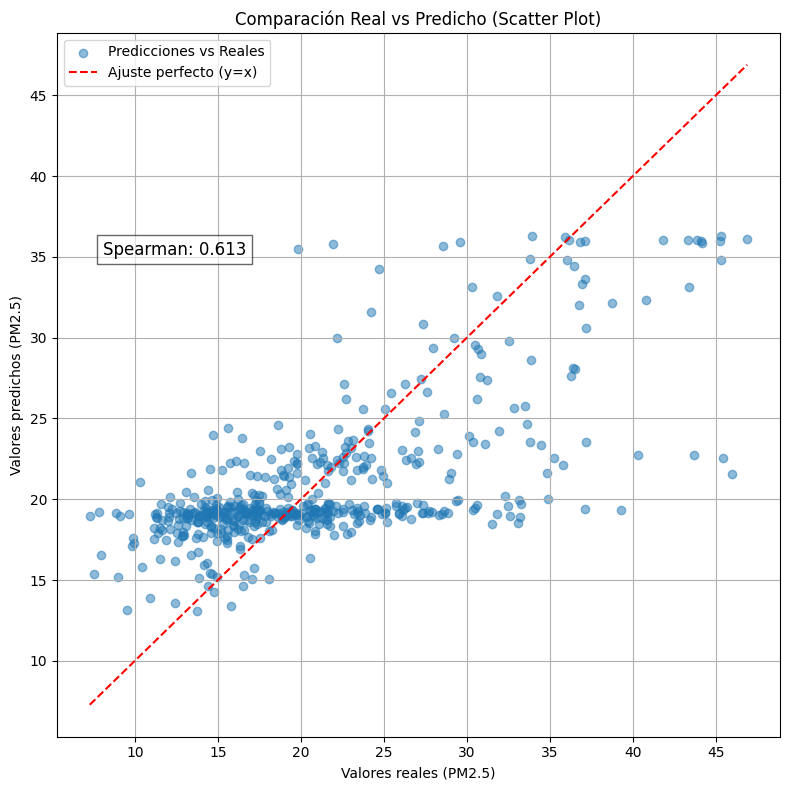

(<matplotlib.legend.Legend at 0x7936b23e5a50>,)

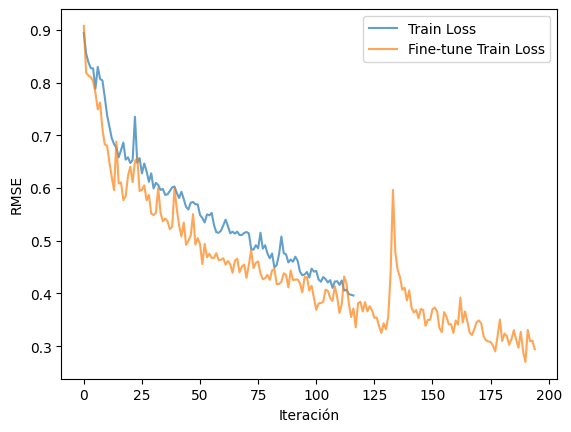

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, cohen_kappa_score
from scipy.stats import pearsonr, spearmanr

# --- Suposiciones ---
# df ya cargado con índice datetime y columnas:
# 'Concentración PM2.5', 'DViento_SSR', 'HAire10_SSR', 'Pliquida_SSR', 'P_SSR', 'TAire10_SSR', 'Viento_SSR'

# Filtrar ventanas temporales
if station_name == 'MED-FISC':
  window1 = df.loc['2021-07-01':'2023-03-31']
  window2 = df.loc['2023-07-01':'2024-04-15']
elif station_name == 'ITA-CONC':
  window1 = df.loc['2016-09-01':'2018-11-28']
  window2 = df.loc['2023-01-01':'2024-06-15']
elif station_name == 'ITA-CJUS':
  window1 = df.loc['2017-01-01':'2022-12-31']
  window2 = df.loc['2022-12-31':'2024-06-15']
else:
  print('Ingrese una estación con calidad del dato adecuada para el modelo')

# Variables predictoras y objetivo
if station_name == 'ITA-CJUS':
  features = ['DViento_SSR', 'HAire10_SSR', 'P_SSR', 'TAire10_SSR', 'VViento_SSR']
  target = 'Concentración PM2.5'
else:
  features = ['DViento_SSR', 'HAire10_SSR', 'PLiquida_SSR', 'P_SSR', 'TAire10_SSR', 'VViento_SSR']
  target = 'Concentración PM2.5'

# Imputación KNN independiente por ventana
imputer1 = KNNImputer(n_neighbors=5)
window1_imputed = imputer1.fit_transform(window1)
window1 = pd.DataFrame(window1_imputed, columns=window1.columns, index=window1.index)

imputer2 = KNNImputer(n_neighbors=5)
window2_imputed = imputer2.fit_transform(window2)
window2 = pd.DataFrame(window2_imputed, columns=window2.columns, index=window2.index)

print("Valores faltantes después de imputación:")
print(window1.isnull().sum())
print(window2.isnull().sum())

# Escalado robusto para mitigar outliers
scaler_x = RobustScaler()
scaler_y = RobustScaler()

X1_scaled = scaler_x.fit_transform(window1[features])
y1_scaled = scaler_y.fit_transform(window1[[target]])

X2_scaled = scaler_x.transform(window2[features])
y2_scaled = scaler_y.transform(window2[[target]])

# Crear secuencias para BI-LSTM
def create_sequences(X, y, time_steps=20):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

from tensorflow.keras import backend as K
def mrse(y_true, y_pred):
    """Función de pérdida personalizada: Mean Root Squared Error (MRSE)"""
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

time_steps = 20

X_train, y_train = create_sequences(X1_scaled, y1_scaled, time_steps)
X_finetune, y_finetune = create_sequences(X2_scaled, y2_scaled, time_steps)

# Definir modelo BI-LSTM
def build_bi_lstm_model():
    model = Sequential()

    model.add(Bidirectional(LSTM(256, return_sequences=True, input_shape=(time_steps, len(features)))))
    model.add(Dropout(0.4))

    # Capa Bidirectional LSTM inicial
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(time_steps, len(features))))
    model.add(Dropout(0.3))

    # Segunda capa Bidirectional LSTM
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))

    # Tercera capa Bidirectional LSTM
    model.add(LSTM(32))
    model.add(Dropout(0.2))

    model.add(Dense(12, 'relu'))
    model.add(Dropout(0.2))

    # Capa de salida
    model.add(Dense(1, 'linear'))

    # Compilación del modelo
    model.compile(optimizer='adam', loss= mrse)
    return model

model = build_bi_lstm_model()

# Entrenamiento ventana 1
es = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=24,
    validation_split=0.2,
    callbacks=[es]
)

# Transfer learning: fine-tuning ventana 2
model.fit(
    X_finetune, y_finetune,
    epochs=200,
    batch_size=24,
    validation_split=0.2,
    callbacks=[es]
)

# Predicciones desescaladas
y_pred_scaled = model.predict(X_finetune)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Valores reales para comparación
y_true = window2[target].iloc[time_steps:].values

# Métricas
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero])) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

pearson_corr, _ = pearsonr(y_true, y_pred)
spearman_corr, _ = spearmanr(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

# Kappa: discretizamos en 5 bins para regresión
bins = 5
y_true_cat = pd.qcut(y_true, bins, labels=False, duplicates='drop')
y_pred_cat = pd.qcut(y_pred, bins, labels=False, duplicates='drop')

kappa = cohen_kappa_score(y_true_cat, y_pred_cat)

print(f'Pearson correlation: {pearson_corr:.4f}')
print(f'Spearman correlation: {spearman_corr:.4f}')
print(f'R2: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'Cohen\'s Kappa (discretizado en {bins} bins): {kappa:.4f}')

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_true[:500], label='Actual', alpha=0.7)
plt.plot(y_pred[:500], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Values (First 500 Samples)')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid()
plt.show()

# Error distribution plot
errors = y_true - y_pred
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50)
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid()
plt.show()

import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Calcular Spearman correlation
spearman_corr, spearman_p_value = spearmanr(y_true, y_pred)

# Crear gráfico
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, label='Predicciones vs Reales')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ajuste perfecto (y=x)')

# Añadir texto con la correlación de Spearman
plt.text(
    min(y_true) + 0.02 * (max(y_true) - min(y_true)),
    max(y_pred) - 0.05 * (max(y_pred) - min(y_pred)),
    f'Spearman: {spearman_corr:.3f}',
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.6)
)

plt.xlabel('Valores reales (PM2.5)')
plt.ylabel('Valores predichos (PM2.5)')
plt.title('Comparación Real vs Predicho (Scatter Plot)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficamos las curvas de entrenamiento y validación
# Para verificar que no existe overfitting
plt.plot(history1.history['loss'], label='Train Loss', alpha=0.7)
plt.plot(history2.history['loss'], label='Fine-tune Train Loss', alpha=0.7)
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend(),

In [ ]:
# Arquiitectura de la red neuronal que acabe de correr

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 20, 512)        │       536,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 20, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 20, 256)        │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 20, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,134,989 (15.77 MB)

 Trainable params: 1,378,329 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,756,660 (10.52 MB)